In [1]:
import numpy as np
import matplotlib.pylab as plt
import sklearn
from skimage import io
import tensorflow as tf
%matplotlib inline

from load_animals import *
from influence.iter_attack import get_projection_to_box_around_orig_point
from influence.inceptionModel import BinaryInceptionModel
from data_poisoning import data_poisoning

from utils import dataset_metadatas, experiment_result_metadata_to_FN, FN_to_experiment_result_metadata, get_dataset, render_img, get_full_model_graph, render_img

%load_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/influence_env/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/influence_env/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/influence_env/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [224]:
def analyze_results(indices_and_poisons_FNs, visualize=False, tsne=False, logits=False, cache={}):
    """
    cache would really save time in execution if provided
    cache["full_model_and_graph"] should give (full_model, full_graph)
    cache["data_sets"] should give (data_sets)
    """
    # Get metadata from file name
    FN_1, FN_2 = indices_and_poisons_FNs
    first_is_indices = FN_to_experiment_result_metadata(FN_1)["contents_type"] == "indices"
    if first_is_indices:
        indices_FN = FN_1
        poisons_FN = FN_2
    else:
        indices_FN = FN_2
        poisons_FN = FN_1
    
    # Get dataset metadata and load dataset
    dataset_name = FN_to_experiment_result_metadata(indices_FN)["dataset_name"]
    dataset_metadata = dataset_metadatas[dataset_name]
    
    # Constants that don't change for Inception (May need to change for other feature extraction methods like Resnet)
    img_side = 299
    num_channels = 3
    
    # Variables used throughout the analysis
    training_dataset_classes = dataset_metadata["classes"]
    num_train_ex_per_class = dataset_metadata["num_train_ex_per_class"]
    num_test_ex_per_class = dataset_metadata["num_test_ex_per_class"]
    num_classes = len(training_dataset_classes)
    num_training_points = num_train_ex_per_class * num_classes
    num_testing_points = num_test_ex_per_class * num_classes
    poisoned_training_points = np.load(poisons_FN)
    poisoned_training_points_indices = np.load(indices_FN)
    target_test_points_indices = [FN_to_experiment_result_metadata(indices_FN)["test_idx"]] # Currently the file name has one test index, need to extend to file names with multiple test indices
    num_target_test_points = len(target_test_points_indices)
    num_poisoned_training_points = len(poisoned_training_points_indices)
    method = FN_to_experiment_result_metadata(indices_FN)["method"]
    
    # load dataset if they're not in the cache
    if cache["data_sets"]:
        data_sets = cache["data_sets"]
    else:
        data_sets = get_dataset(dataset_metadata)

    if visualize:
        # render original training points and poisoned ones
        screen_width = 12.5
        plt.figure(figsize=(screen_width, screen_width/num_poisoned_training_points * 2))
        for i, index_to_poison in enumerate(poisoned_training_points_indices):
            plt.subplot(2,num_poisoned_training_points,i+1)
            plt.title("Original Training Image [{}]".format(index_to_poison))
            render_img(data_sets.train.x[index_to_poison].reshape((img_side,img_side,num_channels)))

        for i, (training_point, index_to_poison) in enumerate(zip(poisoned_training_points, poisoned_training_points_indices)):
            plt.subplot(2,num_poisoned_training_points,num_poisoned_training_points+i+1)
            plt.title("Poisoned Training Image [{}]".format(index_to_poison))
            render_img(training_point.reshape((img_side,img_side,num_channels)))

        # render target test images
        plt.figure(figsize=(screen_width,screen_width/num_target_test_points))
        for target_index in target_test_points_indices:
            plt.subplot(2,num_poisoned_training_points,i+1)
            plt.title("Target test image [{}]".format(target_index))
            render_img(data_sets.test.x[target_index].reshape((img_side,img_side,num_channels)))
        plt.show()
    
    if not tsne and not logits:
        return
    
    print("Setting up full model...")
    # load full model if it's not in the cache argument
    if cache["full_model_and_graph"]:
        full_graph, full_model = cache["full_model_and_graph"]
    else:
        full_graph, full_model = get_full_model_graph(dataset_metadata, data_sets)
    
    if tsne:
        all_dataset_x = np.concatenate([np.copy(data_sets.train.x), 
                                        poisoned_training_points, 
                                        poisoned_training_points_clipped if method == "FC" else [], 
                                        data_sets.test.x[target_test_points_indices]
                                       ], axis = 0)
        all_dataset_labels = np.concatenate([np.copy(data_sets.train.labels),  
                                             np.copy(data_sets.train.labels[poisoned_training_points_indices]), 
                                             np.copy(data_sets.train.labels[poisoned_training_points_indices]) if method == "FC" else [],
                                             data_sets.test.labels[target_test_points_indices]], axis = 0)
        all_dataset = DataSet(all_dataset_x, all_dataset_labels)
        print "Extracting latent space features..."
        with full_graph.as_default():
            all_inceptions = full_model.generate_inception_features(all_dataset, None)
    
        # Calculate tSNE
        from sklearn.manifold import TSNE
        print "Calculating tSNE..."
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=69)
        tsne_results = tsne.fit_transform(all_inceptions)

        plt.figure(figsize=(12,12))
        # plot entire training dataset
        for class_label in range(num_classes):
            class_mask = data_sets.train.labels == class_label
            plt.scatter(tsne_results.T[0][:num_training_points][class_mask], 
                        tsne_results.T[1][:num_training_points][class_mask], 
                        label=training_dataset_classes[class_label]) 

        # plot training points before poison
        plt.scatter(tsne_results.T[0][poisoned_training_points_indices], 
                    tsne_results.T[1][poisoned_training_points_indices], 
                    label="Original Training Points", marker='*', s=200)
        for index, coordinate in zip(poisoned_training_points_indices, tsne_results[poisoned_training_points_indices]):
            plt.annotate(s=str(index), xy = coordinate)
        # plot training points after poison no clipping
        plt.scatter(tsne_results.T[0][num_training_points:num_training_points+num_poisoned_training_points], 
                    tsne_results.T[1][num_training_points:num_training_points+num_poisoned_training_points], 
                    label="Non-rescaled poisoned training point", marker='*', s=200)
        for index, coordinate in zip(poisoned_training_points_indices, tsne_results[num_training_points:num_training_points+num_poisoned_training_points]):
            plt.annotate(s=str(index), xy = coordinate)
        # plot training points after poison with clipping (if applicable)
        if method == "FC":
            plt.scatter(tsne_results.T[0][-num_target_test_points-num_poisoned_training_points:-num_target_test_points], 
                        tsne_results.T[1][-num_target_test_points-num_poisoned_training_points:-num_target_test_points], 
                        label="Rescaled poisoned training point", marker='*', s=200)
            for index, coordinate in zip(poisoned_training_points_indices, tsne_results[-num_target_test_points-num_poisoned_training_points:-num_target_test_points]):
                plt.annotate(s=str(index), xy = coordinate)
        # plot target test points
        plt.scatter( tsne_results.T[0][-num_target_test_points:], tsne_results.T[1][-num_target_test_points:], label="Target test points", marker='*', s=200)
        for index, coordinate in zip(target_test_points_indices, tsne_results[-num_target_test_points:]):
            plt.annotate(s=str(index), xy = coordinate)

        plt.legend()
        plt.show()
    
    if logits:
        print "Training on clean dataset..."
        with full_graph.as_default():
            clean_w = full_model.retrain_and_get_weights(data_sets.train.x, data_sets.train.labels)

        clean_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
        clean_total_test_acc = np.sum(np.argmax(clean_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
        clean_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list

        poisoned_data_set_x = np.copy(data_sets.train.x)
        poisoned_data_set_x[poisoned_training_points_indices] = poisoned_training_points
        poisoned_data_set_labels = np.copy(data_sets.train.labels)

        print "Training on poisoned dataset..."
        with full_graph.as_default():
            poisoned_w = full_model.retrain_and_get_weights(poisoned_data_set_x, poisoned_data_set_labels)

        poisoned_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
        poisoned_total_test_acc = np.sum(np.argmax(poisoned_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
        poisoned_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list

        angle = np.inner(clean_w, poisoned_w)/np.square(np.linalg.norm(clean_w))/np.square(np.linalg.norm(clean_w))
        
        return (clean_total_test_acc, poisoned_total_test_acc), (clean_test_logits, poisoned_test_logits), angle, (clean_w, poisoned_w)

In [225]:
file_names = !ls -t Experiment_results/Experiment_1_redo/
file_names

['Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__28.npy',
 'Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__28.npy',
 'Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__5.npy',
 'Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__5.npy',
 'Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__33.npy',
 'Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__33.npy',
 'Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__80.npy',
 'Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__80.npy',
 'Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__12.npy',
 'Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__12.npy']

In [226]:
source_dir = "Experiment_results/Experiment_1_redo/"
indices_poisons_pairs = []
for i in range(0,len(file_names),2):
    indices_poisons_pairs.append((source_dir+file_names[i], source_dir+file_names[i+1]))
indices_poisons_pairs = indices_poisons_pairs
indices_poisons_pairs

[('Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__28.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__28.npy'),
 ('Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__5.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__5.npy'),
 ('Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__33.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__33.npy'),
 ('Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__80.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__80.npy'),
 ('Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__12.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_

In [232]:
cache = {}
dataset_metadata = dataset_metadatas["Eagle-Mushroom"]
data_sets = get_dataset(dataset_metadata)
cache["data_sets"] = data_sets
cache["full_model_and_graph"] = get_full_model_graph(dataset_metadata, data_sets)

Loading animals from disk...
../data/dataset_Eagle-Mushroom_train-500_test-50.npz
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:191 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
inception_features:  Tensor("flatten/Reshape:0", shape=(?, ?), dtype=float32)
x_poison_features:  Tensor("StridedSlice:0", dtype=float32)
t_target_features:  Tensor("Gather:0", shape=(1, ?), dtype=float32)
Lp:  Tensor("Mean_1:0", dtype=float32)
LP_gradient Tensor("strided_slice_1:0", shape=(?, 268203), dtype=float32)


In [228]:
results = {}
for pair in indices_poisons_pairs:
    result = analyze_results(pair, logits=True, cache = cache)
    results[pair] = result

Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176789530552924]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 8.5613806e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128079


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00263529]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.0005538]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.061007872223854065]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [0.99]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0020253116
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.0403383


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039345]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0003817619872279465]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 6.756664e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128123


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00263933]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00053329]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0008212384418584406]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0018701237
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.0523336


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039346]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038176440284587443]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 9.2966864e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128086


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00282753]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00057536]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0005920015391893685]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0020047028
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.1223395


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039347]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0003817809629254043]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 8.658355e-08
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128048


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00244733]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00053525]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.0007363185868598521]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0036970547
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.9555482


Setting up full model...
Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00169404]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00039344]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.00038174650399014354]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 2.0353107e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 1.6128203


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.00316836]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00065133]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.002380195539444685]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [1.0]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0024244278
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 2.24367


In [230]:
results.keys()

[('Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__12.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__12.npy'),
 ('Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__28.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__28.npy'),
 ('Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__33.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__33.npy'),
 ('Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train_4__80.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__80.npy'),
 ('Experiment_results/Experiment_1_redo/Experiment_1_poisons_IF_Eagle-Mushroom_num_train_4__5.npy',
  'Experiment_results/Experiment_1_redo/Experiment_1_indices_IF_Eagle-Mushroom_num_train

In [231]:
for k,v in results.iteritems():
    FN_1, FN_2 = k
    (acc_c, acc_p), (logits_c, logits_p), angle, (w_c, w_p) = v
    starter = FN_1.split('.')[0]
    np.save(starter+'____'+"acc_angle_result", [acc_c, acc_p, angle])
    np.save(starter+'____'+"logitsClean_result", logits_c)
    np.save(starter+'____'+"logitsPoisoned_result", logits_p)
    np.save(starter+'____'+"wClean_result", w_c)
    np.save(starter+'____'+"wPoisoned_result", w_p)

In [195]:
FNs = !ls Experiment_results/Experiment_1/Dog-Fish/IF/Analysis/
FNs

['Experiment_1_indices_IF_Dog-Fish_num_train_4__351____acc_angle_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__351____logitsClean_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__351____logitsPoisoned_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__351____wClean_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__351____wPoisoned_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____acc_angle_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____logitsClean_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____logitsPoisoned_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____wClean_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_4__416____wPoisoned_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_8__101____acc_angle_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_8__101____logitsClean_result.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_8__101___

In [191]:
starter = "Experiment_results/Experiment_1/Dog-Fish/IF/Analysis/"

In [79]:
d = {
    1:{
        
    },
    2:{
        
    },
    4:{
        
    },
    8:{
        
    },
    16:{
        
    },
}
def add_to_list(dictionary, key, value):
    if key not in dictionary.keys():
        dictionary[key] = [value]
    else:
        dictionary[key].append(value)

for i in range(0, len(FNs), 5):
    test_idx = int(FNs[i].split('_')[9])
    num_train = int(FNs[i].split('_')[7])
    acc_c, acc_p, angle = np.load(starter+FNs[i])
    logits_c = np.load(starter+FNs[i+1])[0]
    logits_p = np.load(starter+FNs[i+2])[0]
    bigger_label = np.argmax(logits_c)
    true_label = int(data_sets.test.labels[test_idx])
    if bigger_label!=true_label:
        print "skipping wrongly labeled {} in {}, {} != {}".format(test_idx, num_train, bigger_label, true_label)
        continue
    add_to_list(d[num_train], "acc_c", acc_c)
    add_to_list(d[num_train], "acc_p", acc_p)
    add_to_list(d[num_train], "angle", angle)
    add_to_list(d[num_train], "true_logit_c", logits_c[true_label])
    add_to_list(d[num_train], "true_logit_p", logits_p[true_label])

skipping wrongly labeled 266 in 8, 1 != 0


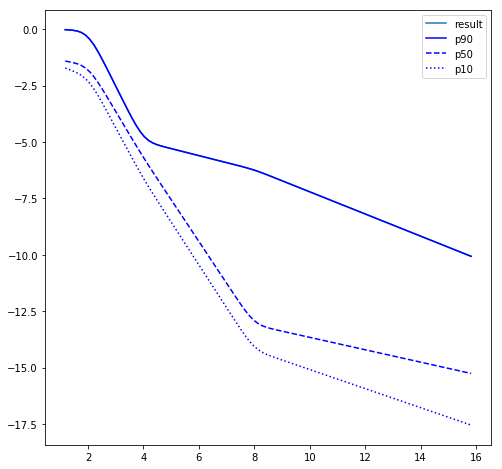

In [189]:

true_logits_p_p90 = []
true_logits_p_p50 = []
true_logits_p_p10 = []
for k in np.sort(d.keys()):
    true_logits_p_p90.append(np.percentile(d[k]["true_logit_p"],90))
    true_logits_p_p50.append(np.percentile(d[k]["true_logit_p"],50))
    true_logits_p_p10.append(np.percentile(d[k]["true_logit_p"],10))

def get_piecewise(x,y):
    def result(x_point):
        if x_point > x.max() or x_point < x.min():
            return None
        if x_point in x:
            index = np.arange(x.shape[0])[x == x_point][0]
            return y[index]
        index_larger = np.arange(x.shape[0])[x > x_point][0]
        index_smaller = np.arange(x.shape[0])[x < x_point][-1]
        assert x[index_larger] > x_point
        assert x[index_smaller] < x_point
        rise = y[index_larger] - y[index_smaller]
        run = x[index_larger] - x[index_smaller]
        slope = float(rise) / float(run)
        delta_x = x_point - x[index_smaller]
        result = y[index_smaller] + slope*delta_x
        return result
    return result


plt.figure(figsize=(8,8))
from scipy.ndimage.filters import gaussian_filter
f = get_piecewise(np.sort(d.keys()), np.log10(true_logits_p_p90))
result = gaussian_filter([[x,f(x)] for x in np.linspace(1,16,100)], [2,1e-4])
plt.plot(result[:,0], result[:,1], label="result")

def plot_smooth(x,y, **kwargs):
    f = get_piecewise(x, y)
    new = gaussian_filter([[x_point, f(x_point)] for x_point in np.linspace(x.min(),x.max(),100)], [2,1e-4])
    plt.plot(new[:,0], new[:,1], **kwargs)

xs = np.sort(d.keys())
plot_smooth(xs, np.log10(true_logits_p_p90), label="p90", color="blue")
plot_smooth(xs, np.log10(true_logits_p_p50), label="p50", color="blue", linestyle="--")
plot_smooth(xs, np.log10(true_logits_p_p10), label="p10", color="blue", linestyle=":")
# plt.plot(np.sort(d.keys()), np.log10(true_logits_p_p10), label="p10")
plt.legend()

In [19]:
"""
    RESULTS IN DIRECTORY MUST HAVE THE RIGHT ORDERING OF FILES FOR EACH TEST POINT
    acc_angle_result.npy
    logitsClean_result.npy
    logitsPoisoned_result.npy
    wClean_result.npy
    wPoisoned_result.npy
"""
def plot_exp_1(directory, log=False, color=None):
    def parse_file_name(fn):
        fn = fn[:-4]
        lst = fn.split('_')
        return (lst[7], lst[9], lst[-2])

    def sorted_dir(folder, order_by_id=False):
        def getmtime(name):
            path = os.path.join(folder, name)
            return os.path.getmtime(path)
        def get_test_idx(name):
            return parse_file_name(name)

        if order_by_id:
            return sorted(os.listdir(folder), key=parse_file_name)

        return sorted(os.listdir(folder), key=getmtime, reverse=True)
    FNs = sorted_dir(directory, True)
    d = {
        1:{},
        2:{},
        4:{},
        8:{},
        16:{},
    }
    def add_to_list(dictionary, key, value):
        if key not in dictionary.keys():
            dictionary[key] = [value]
        else:
            dictionary[key].append(value)

    for i in range(0, len(FNs), 5):
        test_idx = int(FNs[i].split('_')[9])
        num_train = int(FNs[i].split('_')[7])
        method = FNs[i].split('_')[3]
        acc_c, acc_p, angle = np.load(directory+FNs[i])
        logits_c = np.load(directory+FNs[i+1])[0]
        logits_p = np.load(directory+FNs[i+2])[0]
        bigger_label = np.argmax(logits_c)
        true_label = int(data_sets.test.labels[test_idx])
        if bigger_label!=true_label:
            print "skipping wrongly labeled {} in {}, {} != {}".format(test_idx, num_train, bigger_label, true_label)
            continue
        print method, acc_c, acc_p, angle
        add_to_list(d[num_train], "acc_c", acc_c)
        add_to_list(d[num_train], "acc_p", acc_p)
        add_to_list(d[num_train], "angle", angle)
        add_to_list(d[num_train], "true_logit_c", logits_c[true_label])
        add_to_list(d[num_train], "true_logit_p", logits_p[true_label])
    true_logits_p_p90 = []
    true_logits_p_p50 = []
    true_logits_p_p10 = []
    for k in np.sort(d.keys()):
        true_logits_p_p90.append(np.percentile(d[k]["true_logit_p"],90))
        true_logits_p_p50.append(np.percentile(d[k]["true_logit_p"],50))
        true_logits_p_p10.append(np.percentile(d[k]["true_logit_p"],10))

    def get_piecewise(x,y):
        def result(x_point):
            if x_point > x.max() or x_point < x.min():
                return None
            if x_point in x:
                index = np.arange(x.shape[0])[x == x_point][0]
                return y[index]
            index_larger = np.arange(x.shape[0])[x > x_point][0]
            index_smaller = np.arange(x.shape[0])[x < x_point][-1]
            assert x[index_larger] > x_point
            assert x[index_smaller] < x_point
            rise = y[index_larger] - y[index_smaller]
            run = x[index_larger] - x[index_smaller]
            slope = float(rise) / float(run)
            delta_x = x_point - x[index_smaller]
            result = y[index_smaller] + slope*delta_x
            return result
        return result

#     plt.figure(figsize=(8,8))

    def plot_smooth(x,y, **kwargs):
        from scipy.ndimage.filters import gaussian_filter
        f = get_piecewise(x, y)
        new = gaussian_filter([[x_point, f(x_point)] for x_point in np.linspace(x.min(),x.max(),100)], [2,1e-4])
        plt.plot(new[:,0], new[:,1], **kwargs)

    xs = np.sort(d.keys())
    plt.axhline(y=0.5, color="black", linestyle="--")
    f = np.log_10 if log else lambda x:x
    plot_smooth(xs, f(true_logits_p_p90), label="p90", color=color)
    plot_smooth(xs, f(true_logits_p_p50), label="p50", color=color, linestyle="--")
    plot_smooth(xs, f(true_logits_p_p10), label="p10", color=color, linestyle=":")
    plt.ylim([0,1.1])
    # plt.plot(np.sort(d.keys()), np.log10(true_logits_p_p10), label="p10")
    plt.legend()

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz
IF 0.985 0.9833333333333333 0.06116817519068718
IF 0.985 0.9833333333333333 0.061228372156620026
IF 0.985 0.9833333333333333 0.06137564778327942
IF 0.985 0.9833333333333333 0.060552407056093216
IF 0.985 0.985 0.061304040253162384
IF 0.985 0.9766666666666667 0.06084291264414787
IF 0.985 0.98 0.06121516972780228
IF 0.985 0.9783333333333334 0.05265769362449646
IF 0.985 0.9666666666666667 0.05390070751309395
IF 0.985 0.9766666666666667 0.05424700677394867
IF 0.985 0.975 0.052124857902526855
IF 0.985 0.97 0.05351926013827324
IF 0.985 0.9583333333333334 0.0525168813765049
IF 0.985 0.96 0.05577697232365608
IF 0.985 0.9816666666666667 0.06084795668721199
IF 0.985 0.9766666666666667 0.05975603684782982
IF 0.985 0.9833333333333333 0.061041537672281265
IF 0.985 0.9816666666666667 0.060525424778461456
IF 0.985 0.98 0.06120092049241066
IF 0.985 0.9783333333333334 0.060296431183815
IF 0.985 0.98 0.0609784871339798
IF 0.985 

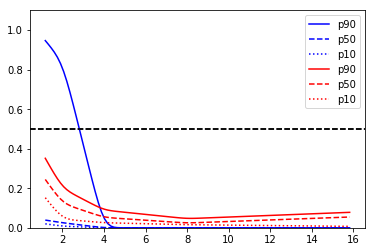

In [20]:
data_sets = get_dataset(dataset_metadatas["Dog-Fish"])
plot_exp_1("Experiment_results/Experiment_1/Dog-Fish/IF/Analysis/", color="blue")
plot_exp_1("Experiment_results/Experiment_1/Dog-Fish/FC/Analysis/", color="red")

Loading animals from disk...
../data/dataset_Eagle-Mushroom_train-500_test-50.npz
IF 1.0 1.0 0.381967157125473
IF 1.0 1.0 0.3857645094394684
IF 1.0 1.0 0.38712143898010254
IF 1.0 1.0 0.3866645097732544
IF 1.0 1.0 0.38422825932502747
IF 1.0 0.99 0.3645175099372864
IF 1.0 0.99 0.35280081629753113
IF 1.0 1.0 0.36774012446403503
IF 1.0 0.99 0.36624428629875183
IF 1.0 0.99 0.3533603549003601
IF 1.0 1.0 0.378662645816803
IF 1.0 0.99 0.3807847797870636
IF 1.0 1.0 0.3834947347640991
IF 1.0 1.0 0.3874838650226593
IF 1.0 1.0 0.38587334752082825
IF 1.0 1.0 0.3734482228755951
IF 1.0 0.99 0.3786921203136444
IF 1.0 1.0 0.38040974736213684
IF 1.0 1.0 0.38221850991249084
IF 1.0 1.0 0.3883073031902313
IF 1.0 0.99 0.3745730221271515
IF 1.0 0.99 0.36560776829719543
IF 1.0 1.0 0.37491485476493835
IF 1.0 0.99 0.3748301863670349
IF 1.0 1.0 0.36866775155067444
FC 1.0 1.0 0.3806179165840149
FC 1.0 0.99 0.3830118477344513
FC 1.0 1.0 0.37391170859336853
FC 1.0 0.99 0.3788919150829315
FC 1.0 0.99 0.3756899833679

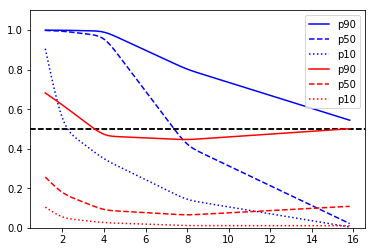

In [21]:
data_sets = get_dataset(dataset_metadatas["Eagle-Mushroom"])
plot_exp_1("Experiment_results/Experiment_1_redo_final/Eagle-Mushroom/IF/Analysis/", color="blue")
plot_exp_1("Experiment_results/Experiment_1_redo_final/Eagle-Mushroom/FC/Analysis/", color="red")